## Imports

In [161]:
import dgl
import numpy as np
import pandas as pd
import networkx as nx
import random
import itertools

from helper_functions import build_map_1

In [162]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv

## Creating the graph:

In [163]:
# CONSTANTS

n_states = 34

In [164]:
G = dgl.DGLGraph()
G.add_nodes(n_states)
u, v = build_map_1()
G = dgl.graph((u, v))

c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\dgl\base.py:45: DGLWarning:

Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.



In [165]:
print(G.number_of_nodes())
print(G.number_of_edges())
print(G)

34
128
Graph(num_nodes=34, num_edges=128,
      ndata_schemes={}
      edata_schemes={})


In [166]:
from node2vec import Node2Vec

In [7]:
node2vec = Node2Vec(G.to_networkx(), dimensions=34, walk_length=10, num_walks=200, workers=6)

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model = node2vec.fit(window=4)

In [9]:
import matplotlib.pyplot as plt
plt.scatter(model.wv.vectors[:, 0], model.wv.vectors[:, 1], c=y_true)

NameError: name 'y_true' is not defined

In [8]:
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)

nx.draw(nx_G, pos, with_labels=True, node_color=[[.9, .3, .3]])
plt.show()

NameError: name 'plt' is not defined

In [167]:
import json
cases = json.load(open("./data/alldata.json", "r"))

In [168]:
states_ = open('./data/state_code_mapping.txt', 'r').read()

In [169]:
name_map_dict = dict([[s.rsplit(" ", 1)[0], s.rsplit(" ", 1)[1]] for s in states_.split('\n')])

## Loading and pre-processing the data:

In [170]:
cases.keys()

dict_keys(['AN', 'AP', 'AR', 'AS', 'BR', 'CH', 'CT', 'DL', 'DN', 'GA', 'GJ', 'HP', 'HR', 'JH', 'JK', 'KA', 'KL', 'LA', 'LD', 'MH', 'ML', 'MN', 'MP', 'MZ', 'NL', 'OR', 'PB', 'PY', 'RJ', 'SK', 'TG', 'TN', 'TR', 'TT', 'UN', 'UP', 'UT', 'WB'])

In [171]:
# manually found this online since data wasn't present in the file
cases['LA']['dates']['2020-06-12']['total']['confirmed'] = 239

In [172]:
with open('./data/states_list.txt', 'r') as file:
    states = file.readlines()

for ind in range(len(states) - 1):
    states[ind] = states[ind][:-1]

In [173]:
df = pd.read_csv("./data/state_data.csv")
df['Population'] = df['Population'].str.replace(",", "").str.replace("\[b\]", "").astype(int)
df.head(5)

,Rank,State or union territory,Population,National Share (%),Decadal growth(2001–2012),Rural population,Percent rural,Urban population,Percent urban,Area[16],Density[a],Sex ratio,Foreign Visits,Health Index
0,1,Uttar Pradesh,199812341,16.51,20.2%,"155,317,278",77.73,"44,495,063",22.27,"240,928 km2 (93,023 sq mi)",828.0,912,4745181,29.16
1,2,Maharashtra,112374333,9.28,20.0%,"61,556,074",54.78,"50,818,259",45.22,"307,713 km2 (118,809 sq mi)",365.0,929,5528704,64.53
2,3,Bihar,104099452,8.60,25.4%,"92,341,436",88.71,"11,758,016",11.29,"94,163 km2 (36,357 sq mi)",1102.0,918,1093141,32.42
3,4,West Bengal,91276115,7.54,13.8%,"62,183,113",68.13,"29,093,002",31.87,"88,752 km2 (34,267 sq mi)",1029.0,953,1656145,58.25
4,5,Madhya Pradesh,72626809,6.00,16.3%,"52,557,404",72.37,"20,069,405",27.63,"308,245 km2 (119,014 sq mi)",236.0,931,327958,38.69


In [174]:
actual_data = pd.read_csv("./data/actual_covid_data_17april.csv")
actual_data = actual_data.drop([0, 37]).reset_index(drop=True)
actual_data = actual_data.drop([32, 35]).reset_index(drop=True)
actual_data.iloc[5, 0] = 'NCT of Delhi'

In [175]:
# replacing with data right before the 1st wave (12th June 2020)

case_data = actual_data[['State', 'Confirmed']]
for state in case_data['State']:
    code = name_map_dict[state]
    case_data[case_data['State'] == state]['Confirmed'] = cases[code]['dates']['2020-06-12']['total']['confirmed'] #/ df[df['State or union territory'] == state]['Population'].values[0]

c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [176]:
case_data['label'] = 0

label_1 = case_data['Confirmed'].quantile(q=1/3)
label_2 = case_data['Confirmed'].quantile(q=2/3)

case_data.iloc[case_data.index[case_data['Confirmed'] >= label_1], 2] = 1
case_data.iloc[case_data.index[case_data['Confirmed'] >= label_2], 2] = 2

c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\siddh\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [177]:
y_true = []
for state in states:
    y_true.append(case_data[case_data['State'] == state]['label'].values[0])
y_true = np.array(y_true)

In [178]:
train_ind = [32, 27, 16, 3, 15, 20]
train_labels = [0, 0, 1, 1, 2, 2]

train_ind = [5, 14, 21, 19, 11, 23] 
train_labels = [1, 0, 2, 1, 2, 0]

test_ind = []
for i in range(n_states):
    if i not in train_ind:
        test_ind.append(i)

In [180]:
#from node2vec import Node2Vec

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
#node2vec = Node2Vec(G.to_networkx(), dimensions=2, walk_length=16, num_walks=200, workers=6)  # Use temp_folder for big graphs

# Embed nodes
#model = node2vec.fit(window=5, 
#                     min_count=1, 
#                     batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

#from sklearn.model_selection import train_test_split
X = np.c_[feats]
y = y_true

X_train, X_val, y_train, y_val = X[train_ind, :], X[test_ind, :], y_true[train_ind], y_true[test_ind]#train_test_split(X, y, test_size=0.8, stratify=y)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=12)
clf.fit(X_train, y_train)
acc = (clf.predict(X_val) == y_val).mean()
print(acc)

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
acc = (clf.predict(X_val) == y_val).mean()
print(acc)

clf = SVC()
clf.fit(X_train, y_train)
acc = (clf.predict(X_val) == y_val).mean()
print(acc)

0.39285714285714285
0.39285714285714285
0.5714285714285714


## Encoding the features:

In [181]:
#embed = nn.Embedding(n_states, n_states)  

#x = torch.arange(0, n_states)
#G.ndata['feat'] = torch.nn.functional.one_hot(x).double()

#for i in range(n_states):
#    G.ndata['feat'][i] = (G.ndata['feat'][i] * df[df['State or union territory'] == states[i]]['National Share (%)'].values[0])
#    print(G.ndata['feat'][i])
# [21, 12, 5, 10, 27, 32]  [2, 1, 1, 2, 0, 0]

In [182]:
for i in train_ind:
    print(y_true[i], states[i], df[df['State or union territory'] == states[i]]['Foreign Visits'].values[0])

1 Haryana 48046
0 Dadra and Nagar Haveli and Daman and Diu 7369
2 Kerala 1189771
1 Telangana 323326
2 Chhattisgarh 6817
0 Sikkim 133388


In [183]:
acc_dict = {
    "svc": [],
    "knn": [],
    "rf" : [],
    "gcn": []
}

In [184]:
# original
train_ind = [32, 27, 16, 3, 15, 20]
train_labels = [0, 0, 1, 1, 2, 2]

train_ind = [18, 12, 5, 10, 30, 32]  
train_labels = [2, 1, 1, 2, 0, 0]

#train_ind = random.sample(range(34), k=6)
#train_labels = [y_true[i] for i in train_ind]

#print(train_ind, train_labels)

#train_ind = random.sample([0, 1, 2, 3, 4, 5, 32, 33, 7], k=1) + random.sample([6, 9, 14, 15, 10], k=1) + random.sample([17, 18, 19, 20, 21, 22, 31], k=2) + random.sample([8, 11, 12, 13, 16], k=1) + random.sample([23, 24, 25, 26, 27, 28, 29, 30], k=1) 
#train_labels = [y_true[i] for i in train_ind]

# .82
train_ind = [5, 14, 21, 19, 11, 23] 
train_labels = [1, 0, 2, 1, 2, 0]

#train_ind = [30, 10, 20, 12, 32, 14] 
#train_labels = [y_true[i] for i in train_ind]

print(train_ind, train_labels)
test_ind = []
for i in range(n_states):
    if i not in train_ind:
        test_ind.append(i)

n_feats = 2
feats = torch.zeros(n_states, n_feats)
for i in range(n_states):
    
    density = df[df['State or union territory'] == states[i]]['Density[a]'].values[0]
    percent_urban = df[df['State or union territory'] == states[i]]['Percent urban'].values[0]
    health_index = df[df['State or union territory'] == states[i]]['Health Index'].values[0]
    foreign_visits = df[df['State or union territory'] == states[i]]['Foreign Visits'].values[0]
    percent_rural = df[df['State or union territory'] == states[i]]['Percent rural'].values[0]
    share = df[df['State or union territory'] == states[i]]['National Share (%)'].values[0]
    
    # adding the features we want: 
    feats[i] = (torch.Tensor([foreign_visits, density]))
    
feats = (feats - feats[train_ind, :].mean(axis=0)) / feats[train_ind, :].std(axis=0)

[5, 14, 21, 19, 11, 23] [1, 0, 2, 1, 2, 0]


In [193]:
our_data = feats[train_ind, :]

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=32)
clf.fit(our_data, train_labels)
acc = (clf.predict(feats)[test_ind] == y_true[test_ind]).mean()
print(acc)
#acc_dict['rf'].append(acc)

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(our_data, train_labels)
acc = (clf.predict(feats)[test_ind] == y_true[test_ind]).mean()
print(acc)
#acc_dict['knn'].append(acc)     

clf = SVC()
clf.fit(our_data, train_labels)
acc = (clf.predict(feats)[test_ind] == y_true[test_ind]).mean()
print(acc)
#acc_dict['svc'].append(acc)

0.6785714285714286
0.35714285714285715
0.5714285714285714


## Creating and training the model:

In [194]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, hidden_size)
        self.lin = torch.nn.Linear(hidden_size, 3)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = F.leaky_relu(h)
        h = self.conv2(g, h)
        h = F.leaky_relu(h)
        h = self.lin(h)
        return h

In [272]:
#embed = nn.Embedding(n_states, n_feats)  
#inputs = embed.weight
#labeled_nodes = torch.tensor([32, 27, 3, 4, 15, 20])  
#labels = torch.tensor([0, 0, 1, 1, 2, 2])  

labeled_nodes = torch.tensor(train_ind)  
labels = torch.tensor(train_labels) 

epochs = 200
net = GCN(n_feats, 12, 3)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []

for epoch in range(epochs + 1):
    logits = net(G, feats)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, dim=1)
    loss = F.nll_loss(logp[labeled_nodes], labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_acc = (np.array(y_true)[train_ind] == all_logits[-1].argmax(axis=1).numpy()[train_ind]).mean()
        test_acc = (np.array(y_true)[test_ind] == all_logits[-1].argmax(axis=1).numpy()[test_ind]).mean()
        #print(f'Epoch: {epoch}\nLoss: {round(loss.item(), 4)} Test Accuracy: {round(acc, 4)} Train Acc: {round(acc2, 4)}')
        print("Epoch: %3d Train Loss: %.4f Train Acc: %.4f Val Acc: %.4f" % (epoch, round(loss.item(), 4), round(train_acc, 4), round(test_acc, 4)))
        if round(train_acc, 4) == 1:#0.8214:
            break

Epoch:   0 Train Loss: 1.0924 Train Acc: 0.3333 Val Acc: 0.3214
Epoch:  20 Train Loss: 0.7811 Train Acc: 0.6667 Val Acc: 0.7857
Epoch:  40 Train Loss: 0.4720 Train Acc: 0.8333 Val Acc: 0.6071
Epoch:  60 Train Loss: 0.1732 Train Acc: 1.0000 Val Acc: 0.7500


In [220]:
y_true

array([0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 0, 2, 1, 1, 2, 1, 2, 2,
       2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int64)

In [221]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [247]:
plot_df = pd.DataFrame(all_logits[0].numpy())
plot_df['col'] = y_true

In [248]:
fig = px.scatter_3d(plot_df, x=0, y=1, z=2,
                    color='col',
                    title="3D Scatter Plot")
fig.show()

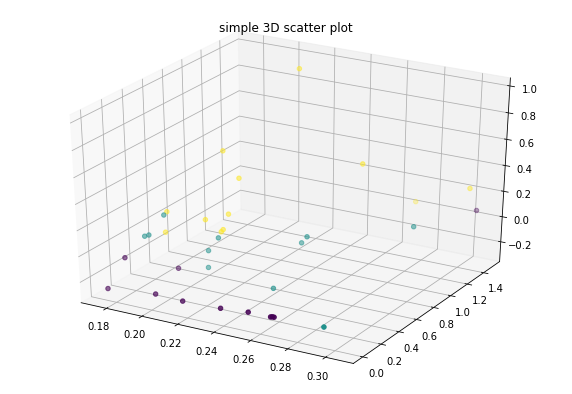

In [60]:
z = np.random.randint(100, size =(50))
x = np.random.randint(80, size =(50))
y = np.random.randint(60, size =(50))
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(all_logits[0][:, 0], all_logits[0][:, 1], all_logits[0][:, 2], c=y_true)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

In [56]:
all_logits[0][:, 0]

tensor([0.1995, 0.2460, 0.2882, 0.2440, 0.2095, 0.2476, 0.3019, 0.2568, 0.2070,
        0.1841, 0.2105, 0.2100, 0.2103, 0.1862, 0.1754, 0.1958, 0.1808, 0.1796,
        0.2079, 0.1834, 0.2018, 0.2113, 0.2122, 0.1750, 0.2491, 0.2883, 0.2148,
        0.2609, 0.2349, 0.2626, 0.2617, 0.1971, 0.3051, 0.2751])

In [192]:
test_acc = (np.array(y_true)[:] == all_logits[-1].argmax(axis=1).numpy()[:]).mean()
print(test_acc)
#acc_dict['gcn'].append(test_acc)

0.8823529411764706


In [200]:
#list(map(lambda el: acc_dict[el].pop(), acc_dict))

In [181]:
acc_dict

{'svc': [0.39285714285714285,
  0.42857142857142855,
  0.35714285714285715,
  0.32142857142857145,
  0.39285714285714285,
  0.5,
  0.2857142857142857,
  0.32142857142857145,
  0.42857142857142855,
  0.5714285714285714],
 'knn': [0.32142857142857145,
  0.39285714285714285,
  0.35714285714285715,
  0.42857142857142855,
  0.32142857142857145,
  0.32142857142857145,
  0.2857142857142857,
  0.2857142857142857,
  0.35714285714285715,
  0.35714285714285715],
 'rf': [0.35714285714285715,
  0.6428571428571429,
  0.6428571428571429,
  0.5,
  0.5714285714285714,
  0.5714285714285714,
  0.5357142857142857,
  0.6785714285714286,
  0.5,
  0.6071428571428571],
 'gcn': [0.6071428571428571,
  0.6785714285714286,
  0.75,
  0.6428571428571429,
  0.6071428571428571,
  0.7142857142857143,
  0.6071428571428571,
  0.7142857142857143,
  0.5714285714285714,
  0.7857142857142857]}

In [263]:
for mod in acc_dict:
    print(mod, max(acc_dict[mod]), sum(acc_dict[mod]) / len(acc_dict[mod]))

svc 0.5714285714285714 0.4
knn 0.42857142857142855 0.34285714285714286
rf 0.6785714285714286 0.5607142857142857
gcn 0.8214 0.6714257142857142


## Results:

In [388]:
op_df = pd.DataFrame(all_logits[-1][:].numpy())
op_list = []

for i in range(n_states):
    op_list.append((all_logits[-1][i].numpy().argmax()))

op_df['preds'] = pd.Series(op_list)
op_df['State'] = states

In [389]:
final_df = pd.merge(op_df, case_data, on='State')#.sort_values('label', ascending=False)[['State', 'preds', 'label']]
(final_df['preds'] == final_df['label']).mean()

0.8823529411764706

In [390]:
final_df

,0,1,2,preds,State,Confirmed,label
0,8.336432,2.739926,-6.445020,0,Ladakh,11709,0
1,1.359403,1.620766,-5.881773,1,Jammu and Kashmir,145166,1
2,-10.149055,-0.705744,-4.284385,1,Himachal Pradesh,75587,1
3,-4.837475,0.020606,-4.378413,1,Punjab,290707,1
4,-2.374469,0.079920,-2.926488,1,Uttarakhand,121403,1
5,-6.507901,-0.980952,-2.242189,1,Haryana,342077,1
6,-20.968472,-3.912248,0.516029,2,Rajasthan,404355,2
7,-13.620948,-2.756685,0.532975,2,Uttar Pradesh,821054,2
8,-4.334144,-0.934465,-1.348792,1,Bihar,307557,1
9,-1.968250,-0.765931,-0.761814,2,Gujarat,384688,2


In [391]:
final_df['preds'].value_counts()

2    13
1    11
0    10
Name: preds, dtype: int64

In [392]:
final_df['label'].value_counts()

2    12
1    11
0    11
Name: label, dtype: int64

In [393]:
final_df[final_df['preds'] != final_df['label']]

,0,1,2,preds,State,Confirmed,label
13,-0.201365,0.328390,-2.808434,1,West Bengal,651508,2
25,17.630684,7.942176,-14.792749,0,Assam,222940,1
31,-4.254689,-1.394898,-0.063553,2,Puducherry,47108,0
32,-23.397354,-4.299700,0.356637,2,Chandigarh,32878,0


In [394]:
#!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py

In [395]:
st = '''Andhra Pradesh	15.91°N	79.74°E
Arunachal Pradesh	28.21°N	94.72°E
Assam	26.20°N	92.93°E
Bihar	25.09°N	85.31°E
Chhattisgarh	21.27°N	81.86°E
Goa	15.29°N	74.12°E
Gujarat	22.25°N	71.19°E
Haryana	29.05°N	76.08°E
Himachal Pradesh	31.10°N	77.17°E
Jammu and Kashmir	33.77 °N	76.57°E
Jharkhand	23.61°N	85.27°E
Karnataka	15.31°N	75.71°E
Kerala	10.85°N	76.27°E
Madhya Pradesh	22.97°N	78.65°E
Maharashtra	19.75°N	75.71°E
Manipur	24.66°N	93.90°E
Meghalaya	25.46°N	91.36°E
Mizoram	23.16°N	92.93°E
Nagaland	26.15°N	94.56°E
Odisha	20.95°N	85.09°E
Punjab	31.14°N	75.34°E
Rajasthan	27.02°N	74.21°E
Sikkim	27.53°N	88.51°E
Tamil Nadu	11.12°N	78.65°E
Tripura	23.94°N	91.98°E
Uttarakhand	30.06°N	79.01°E
Uttar Pradesh	26.84°N	80.94°E
West Bengal	22.98°N	87.85°E'''

In [396]:
arr = st.split('\n')
vals = []

for i, ar in enumerate(arr):
    d = arr[i].split('\t')
    vals.append([d[0], float(d[1][:-2].strip()), float(d[2][:-2].strip())])
    
vals.append(['Dadra and Nagar Haveli and Daman and Diu', 20.26657819, 73.0166178])
vals.append(['Ladakh', 34.2268, 77.5619])
vals.append(['Puducherry', 11.9416, 79.8083])
vals.append(['NCT of Delhi',28.7041, 77.1025])
vals.append(['Chandigarh', 30.7333, 76.7794])
vals.append(['Telangana', 18.1124, 79.0193])

In [397]:
res = []
for i in states:
    f = False
    for st in vals:
        if st[0] == i:
            res.append(st)
            f = True
            break
    if not f:
        print(i)

In [398]:
final_df['lat'] = [val[1] for val in res]
final_df['long'] = [val[2] for val in res]

In [399]:
fig = px.scatter_geo(final_df, 
                     lat="lat", 
                     lon="long", 
                     color='label', 
                     size=final_df['label']+1, 
                     scope='asia', 
                     center={'lat':19,'lon':-99}, 
                     width=800, 
                     text=final_df['State'],
                     projection="natural earth")

fig.show()

'''
Chandigarh
Nagaland
Odisha
Punjab
Maharashtra
Andhra Pradesh
'''

'\nChandigarh\nNagaland\nOdisha\nPunjab\nMaharashtra\nAndhra Pradesh\n'

In [411]:
fig = px.scatter_geo(final_df, 
                     lat="lat", 
                     lon="long", 
                     color='preds', 
                     size=final_df['preds']+1, 
                     scope='asia', 
                     center={'lat':19,'lon':-99}, 
                     width=800, 
                     text=final_df['State'],
                     projection="natural earth")

fig.show()